<a href="https://colab.research.google.com/github/mmeisser/python_tools/blob/master/test_PARSE_%26_PROCESS_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROCESS loadcell raw values

This notebook/python script does read log files collected with akra (v1.26.4 or above)

## 1. LOAD

### A. select individual file

First select the file to upload:

(run the below code section)

In [13]:
from google.colab import files
uploaded = files.upload()

#uploaded #uncomment to check the content of file



Saving 9_SartoInput_8.6.2021_10h22min29sec303.csv to 9_SartoInput_8.6.2021_10h22min29sec303.csv


### B. load data into system

Then load the (selected) file into a (panda) data frame

**IMPORTANT:** *replace the name of the file you just loaded into the file_to_analyze below*

before you hit "play" on the cell below ...

In [14]:
import pandas as pd
import io

#Sample from SartoTestTool
#file_to_analyze = 'FastSurfaceImpact-1.csv'
#file_to_analyze = 'PA3-212-AkraNIBSticking.csv'
#file_to_analyze = 'SartoToolTest-Edge-20210302-094100-V2.csv'
file_to_analyze = '9_SartoInput_8.6.2021_10h22min29sec303.csv'

df = pd.read_csv(io.StringIO(uploaded[file_to_analyze].decode('utf-8')))
#df #uncomment to show the loaded table

### C. Aquire all data series

Process the data and spit out a graph

In [15]:
 import plotly.graph_objs as go
import csv
#import matplotlib.pyplot as plt
#import plotly.express as px

akra_log_filetype = True
#detect CSV file format (akra vs sarto input tool)
if ' Device type' in df:
  print("Detected Akra file format")
  is_primary = df[' Device type']== ' Primary' #this is a column with true/false to assert if this is data for a controller
  stylus_data = df[is_primary]    #therefore we only take that subset of lines for the controller (ie stylus)
  #---Original (issues with type conversion)
  #time_zero = int(float(stylus_data.iloc[0]['TimeStamp (ms)'])*1000)
  #time=(stylus_data['TimeStamp (ms)']*1000).apply(lambda val: (val-time_zero))  # in csv file time unit is actually seconds, so we need to convert into ms (and remove initial time as t0)
  #---Alternative---
  time_zero=float(stylus_data['TimeStamp (ms)'].array[0])*1000
  time=(stylus_data['TimeStamp (ms)']).apply(lambda val: int((float(val)*1000 - time_zero)))  # in csv file time unit is actually seconds, so we need to convert into ms (and remove initial time as t0)
  print("time zero reference:" + str(time_zero))
  print (time.head())
else:
  print("Detected SartoTestTool file format")
  akra_log_filetype = False
  stylus_data = df
  time_zero=int(stylus_data['TimeStamp (sec)'].array[0]*1000)
  time=(stylus_data['TimeStamp (sec)']*1000).apply(lambda val: int(val-time_zero)) 
  print("time zero reference:" + str(time_zero))
  print (time.head())

# this is true if RAW MODE LOADCELL is being used on stylus:
# -> get RAW nib and primary dataseries as integer (stored into touchpad axis)
nib=(stylus_data[' Touchpad X value']*32768).apply(lambda val: int(val))
primary=(stylus_data[' Touchpad Y value']*32768).apply(lambda val: int(val))

#get nib&pri output (openXR)
nibout=(stylus_data[' Nib value']).apply(lambda val: float(val))
priout=(stylus_data[' Primary value']).apply(lambda val: float(val))
# note on grip: with a special FW on stylus we use that to store real (raw) fw baseline
# format it that the int16 value is converted into a uint12, scaled to max 4095, therefore we need to apply "-" sign and multiply it by 4095
gripout=(stylus_data[' Grip value']).apply(lambda val: float(-val)*4095) 

#tip trajectory. Unity reference is that 
#warning: due to negative numbers, first column could be seen as string, (instead of float)
if akra_log_filetype:
  xs=stylus_data[' Position x'].astype(float)
  ys=stylus_data[' Position y']
  zs=stylus_data[' Position z']
else:
  xs=stylus_data[' Controller position x'].astype(float)
  print (xs.head())
  ys=stylus_data[' Controller position y']
  zs=stylus_data[' Controller position z']
  print (zs.head())
 
# Y is the distance above a flat surface, ie heigth
# X, Z are coordinates in a plane parallel to ground
height = ys
surface_x = xs
surface_y = zs


# plot graph with all series
fig = go.Figure([
    go.Scatter(
        name='Nib (raw)',
        y=nib,
        mode='lines',
        marker=dict(color='blue', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='Primary (raw)',
        y=primary,
        mode='lines',
        marker=dict(color='red', size=2),
        showlegend=True
    ),
])
fig.update_layout(
    yaxis_title='adc raw value [counts]',
    xaxis_title='samples (not time)',
    title=file_to_analyze,
    hovermode="x"
)
fig.show()

Detected SartoTestTool file format
time zero reference:7521
0     0
1     0
2    20
3    27
4    39
Name: TimeStamp (sec), dtype: int64
0    0.118249
1    0.118323
2    0.118322
3    0.118320
4    0.118351
Name:  Controller position x, dtype: float64
0    0.306324
1    0.306561
2    0.306581
3    0.306607
4    0.306599
Name:  Controller position z, dtype: float64


## 2. PLOTS

### Plot stylus NIB ADC vs heigth




In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig2 = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig2.add_trace(
    go.Scatter(x=time, y=nib, name="adc counts"),
    secondary_y=False,
)

fig2.add_trace(
    go.Scatter(x=time, y=height, name="heigth"),
    secondary_y=True,
)

# Add figure title
fig2.update_layout(
    title_text="Nib values vs heigth"
)

# Set x-axis title
fig2.update_xaxes(title_text="timestamp (ms)")

# Set y-axes titles
fig2.update_yaxes(title_text="<b>Nib</b>  (adc counts)", secondary_y=False)
fig2.update_yaxes(title_text="<b>Heigth (Y)</b> (in m)", secondary_y=True)

fig2.show()

### Plot NIB vs XR output (0-1)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig2b = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig2b.add_trace(
    go.Scatter(x=time, y=nibout, name="nib XRInput", marker=dict(color='yellow', size=2)),
    secondary_y=False,
)

fig2b.add_trace(
    go.Scatter(x=time, y=height, name="heigth"),
    secondary_y=True,
)

# Add figure title
fig2b.update_layout(
    title_text="Nib values vs heigth"
)

# Set x-axis title
fig2b.update_xaxes(title_text="timestamp (ms)")

# Set y-axes titles
fig2b.update_yaxes(title_text="<b>Nib</b>  (0-1 XRInput)", secondary_y=False)
fig2b.update_yaxes(title_text="<b>Heigth (Y)</b> (in m)", secondary_y=True)

fig2b.show()

### Plot in 3D

In [17]:
import plotly.express as px

# in unity (csv file format) the Y is the HEIGHT, and X and Z are coordinates on a surface parallel to world surface for the user
# therefore we use this mapping where Z for the graph takes ys dataset, and others accordingly.
#fig = px.line_3d(stylus_data, x=xs, y=zs, z=ys)
#fig.show()

fig = go.Figure(data=[go.Scatter3d(x=xs, y=zs, z=ys, marker=dict(
        size=4,
        color=nib,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=1
    ))])

fig.update_layout(width=1500,height=1000)

fig.show()

##3. ANALYSIS

First setup some variable params

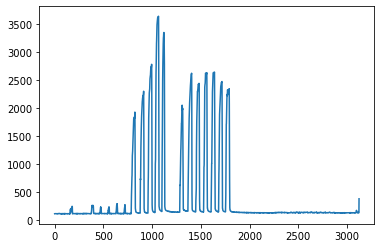

In [18]:
#@title Variable Parameters { run: "auto", form-width: "50%" }
#last_frame = nib.count()
first_frame = 0 #@param {type:"integer"}
last_frame = 6000 #@param {type:"integer"}
gF_ADC_count = 2 #@param {type:"slider", min:0, max:2, step:0.1}

import matplotlib.pyplot as plt
plt.plot(nib.iloc[first_frame:last_frame])

### plot minimum data (useful for baseline)

NIB: min=109 max=3633
PRI: min=-1128 max=6390


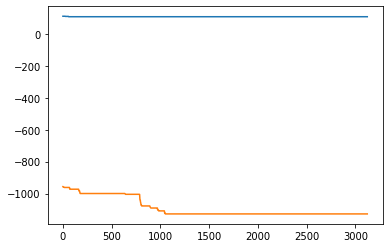

In [19]:
s = pd.Series(nib) #create a panda serie from NIB LOADCELL data
s.describe() #prints out stats data on serie

t = pd.Series(time) #create a panda serie from time data
t.diff()   #gives differences between samples in serie


# detect baseline (simple minimum for now) for NIB
minimum_nib = nib.array[0]
minimum_nib_array = nib.copy()

for index, value in enumerate(nib.array):
 if value < minimum_nib:
   minimum_nib = value #if we found a smaller value
 #print("Index:"+ str(index) + " - min" + str(minimum_nib))
 minimum_nib_array.array[index] = minimum_nib # place it into the array
#plt.plot(minimum_nib_array)

# detect baseline (simple minimum for now) for NIB
minimum_pri = primary.array[0]
minimum_pri_array = primary.copy()

for index, value in enumerate(primary.array):
 if value < minimum_pri:
   minimum_pri = value
 #print("Index:"+ str(index) + " - min" + str(minimum_pri))
 minimum_pri_array.array[index] = minimum_pri
#plt.plot(minimum_pri_array)

#Here you can plot how the minimum values captured in the log do change overtime

plt.plot(minimum_nib_array.iloc[first_frame:last_frame])
plt.plot(minimum_pri_array.iloc[first_frame:last_frame])

nibmin = nib.iloc[first_frame:last_frame].min()
nibmax = nib.iloc[first_frame:last_frame].max()
primin = primary.iloc[first_frame:last_frame].min()
primax = primary.iloc[first_frame:last_frame].max()

nibfullrange = nibmin-nibmax
prifullrange = primin-primax

##force to othervalues if needed
nibfullrange = 210

print("NIB: min="+str(nibmin)+ " max="+ str(nibmax))
print("PRI: min="+str(primin)+ " max="+ str(primax))

## 4. BASELINE

### Parameters

algos parameters used to:
- evaluate the ACTIVITY and other indicators
- parametrize the baseline algo

In [20]:
Tolerance_Margin   = 14	    #counts
Baseline_Margin	   = 2	    #counts
Activity_Margin	   = 3	    #counts
Baseline_Threshold = 2	    #counts
Filter_Threshold	 = 0.25	  #NA
Activity_Window	   = 10	    #samples
Activity_Window_Time = 2000 #in ms
Filter_Window	     = 20 	  #samples
Raw_Window	       = 10	    #samples
Raw_Weight_Min	   = 9	    #samples
Raw_Weight_Max	   = 1	    #samples
Elastic_Force	     = 23	    #gf
Time_Constant	     = 105	  #samples
Max_Force	         = 400	  #gf

print ( "DATA SERIES infos:")
print ( "--> samples  = "+str(nib.size))
print ( "--> duration = "+str(time.array[time.size-1]) + "ms")
print ( "--> window   = " +str(Activity_Window_Time)+"ms")
print ( "--> nib signal full range = "+ str(nibfullrange))







DATA SERIES infos:
--> samples  = 3124
--> duration = 43539ms
--> window   = 2000ms
--> nib signal full range = 210


### Actual Baseline (simulated fw implementation)
**Activity window**:
the series is chuncked into windows of "Activity_Window_Time" ms

In [9]:
# PARAMETERS used in fw (2.0.0)
#-------------------------------------
Activity_Window_Time = 2000 #in ms
Activity_Margin	   = 10	    #counts
Baseline_Margin	   = 2	    #counts

#create the baseline data serie
#-------------------------------------
baseline = nib.copy()
min_baseline = int(nib.array[2]) #starting value / zeroing


# evaluate activity window (number of samples) starting from a time window
#-------------------------------------
for index, value in enumerate(time.array):
  #print ("index=" + str(index) + " Value=" + str(value))
  if value > Activity_Window_Time:
    Activity_Window = index
    break
print("--> window samples = " + str(Activity_Window)+"\n\n")

#parse the nib data to calculate baseline
#-------------------------------------
print("... parsing the data")
for index, value in enumerate(nib.array):
 if index > nib.array.size / Activity_Window:
  break

 window = index*Activity_Window #int(index/Activity_Window)
 #print(repr(nib.iloc[window:window+Activity_Window]))
 min = int(nib.iloc[window:window+Activity_Window].min())
 max = int(nib.iloc[window:window+Activity_Window].max())

 #print("window:%d - min:%d - max:%d" %( index,min, max) )  

 if (abs(min)-abs(max)) < Activity_Margin:
  #very little activity in chunk: we can consider this as new baseline
  min_baseline = min
  print("update baseline")
 else:
  #too much activity: user, do not udpate baseline
  print("too much user activity")

 #if min < min_baseline: #found a new min
 #  min_baseline = min

 #update the baseline serie data (whole window) with same data
 for i in range(Activity_Window):
  if ((index*Activity_Window+i) >= nib.size): #take into account incomplete chunks
   break
  baseline.array[index*Activity_Window+i] = min_baseline
  #print(repr(baseline.iloc[window:window+Activity_Window]))

baseline_threshold = baseline.apply(lambda val: int(val+ Baseline_Margin))

# generate (simulated) output data stream
output = nib.subtract(baseline_threshold, fill_value=0)
#scale output to max range (for now), not having calibration data to know what max scale is
output = output.apply(lambda val: float(val/abs(nibfullrange)))
for index, value in enumerate(output):
  if (value < 0):
    output.array[index]=0



--> window samples = 144


... parsing the data
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update baseline
update b

#### Baseline plot

The graph here below is simply a representation of the same graph, with a different scale for the OUTPUT (green)

In [10]:
from plotly.subplots import make_subplots

fig4 = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig4.add_trace(
    go.Scatter(x=time, y=nib, name="nib", marker=dict(color='blue', size=2)),
    secondary_y=False,
)

fig4.add_trace(
    go.Scatter(x=time, y=baseline, name="baseline (sim)", marker=dict(color='red', size=2)),
    secondary_y=False,
)

#fig4.add_trace(go.Scatter(x=time, y=baseline_threshold, name="baseline threshold", marker=dict(color='cyan', size=2)),secondary_y=False,)


fig4.add_trace(
    go.Scatter(x=time, y=gripout, name="baseline (fw)", marker=dict(color='orange', size=2)),
    secondary_y=False,
)

fig4.add_trace(
    go.Scatter(x=time, y=nibout, name="nib (real) output", marker=dict(color='yellow', size=2)),
    secondary_y=True,
)

fig4.add_trace(
    go.Scatter(x=time, y=output, name="nib (sim) output", marker=dict(color='green', size=2)),
    secondary_y=True,
)

height = height.apply(lambda val: (val*10+3)) #use this to bring it to correct level

fig4.add_trace(
    go.Scatter(x=time, y=height, name="height", marker=dict(color='pink', size=2)),
    secondary_y=True,
)

# Add figure title
fig4.update_layout(
    title_text="Nib, baseline & outputs"
)

# Set x-axis title
fig4.update_xaxes(title_text="timestamp (ms)")

# Set y-axes titles
fig4.update_yaxes(title_text="<b>Input</b>  (adc counts)", secondary_y=False, range=(-350, -100))
fig4.update_yaxes(title_text="<b>output</b> (0-1)", secondary_y=True, range=(-1, 1))

fig4.show()

#### Another View (outputs to system)
-  nib (raw) 
- and real output (as sent to HMD) for nib and primary (on trigger channel)

In [11]:
fig5 = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig5.add_trace(go.Scatter(x=time, y=nib, name="nib (raw)", marker=dict(color='blue', size=2)),secondary_y=False,)
fig5.add_trace(go.Scatter(x=time, y=nibout, name="Nib output", marker=dict(color='purple', size=2)),secondary_y=True,)
#fig5.add_trace(go.Scatter(x=time, y=priout, name="Pri output", marker=dict(color='pink', size=2)),secondary_y=True,)

# Add figure title
fig5.update_layout(title_text="Nib, baseline & outputs")

# Set x-axis title
fig5.update_xaxes(title_text="timestamp (ms)")

# Set y-axes titles
fig5.update_yaxes(title_text="<b>Input</b>  (adc counts)", secondary_y=False, range=(-350, 0))
fig5.update_yaxes(title_text="<b>output</b> (0-1 range)", secondary_y=True, range=(0, 1))

fig5.show()

### Baseline v2

In [12]:
# PARAMETERS 
#-------------------------------------
#Activity_Window_Time = 2000 #in ms
Activity_Margin	   = 2	    #counts
Baseline_Margin	   = 2	    #counts
Tolerance_Margin   = 14	    #counts
Activity_Window	   = 20	    #samples
Activity_Window_long	   = 100	    #samples


#create the baseline data serie
#-------------------------------------
min = nib.copy()
max = nib.copy()
activity = nib.copy()
activity_tolerance = nib.copy()
activity_mean = nib.copy()
baseline = nib.copy()
accumulate = nib.copy()
accumulate_mean = nib.copy()
very_minimum = nib.array[2]


buffer_start_index = 0

#parse the nib data to calculate baseline
#-------------------------------------
print("... parsing the data (smaller window)")
for index, value in enumerate(nib.array):

 if value < very_minimum:
   very_minimum = value

 #we first need to the correct amount of samples 
 if index > Activity_Window:
   buffer = nib.iloc[index-Activity_Window:index]
   #print(buffer.head())
   #print ("buffer min=" + str(buffer.min()))

   min.array[index] = buffer.min()
   max.array[index] = buffer.max()

   activity.array[index] = buffer.max() - buffer.min()

   activity_buffer = activity.iloc[index-Activity_Window:index]
   activity_mean.array[index] = activity_buffer.median()

   if (nib.array[index]  > (buffer.min() + Tolerance_Margin)):
    activity_tolerance.array[index] = 10
   else:
    activity_tolerance.array[index] = 0


   # EVALUATE the baseline
   #-------------------------------------
   # 1. evaluate if activity (max-min) is below a threshold
   if (activity.array[index] < Activity_Margin) and (activity_mean.array[index] < 3) and abs(int(accumulate_mean.array[index]) <1 ): # and (abs(min.array[index]) > abs(min.array[index-2])):
     #update baseline
     baseline.array[index] = buffer.min() # by taking the minimum of the whole serie(buffer)
   # 2. follow the smallest value ever in any case
   elif (value < baseline.array[index-1]):
     baseline.array[index] = value
   else:
     baseline.array[index] = baseline.array[index-1] #take previous 

   # evaluate another indicator value in attempt to
   # indicate the activity within the buffer period   
   accumulate_temp =0
   for i, value in enumerate(buffer.array):
     if i > 0:
      accumulate_temp = accumulate_temp + (buffer.array[i]-buffer.array[i-1]) #difference between samples
   accumulate.array[index] = accumulate_temp
   subset_accumulate = accumulate.iloc[index-Activity_Window:index]
   accumulate_mean.array[index] = subset_accumulate.median()

#-------------------------------------
print("... parsing the data (longer window)")

min_long = nib.copy()
max_long = nib.copy()
activity_long = nib.copy()

for index, value in enumerate(nib.array):
 #we first need to the correct amount of samples 
 if index > Activity_Window_long:
   buffer = nib.iloc[index-Activity_Window_long:index]
   min_long.array[index] = buffer.min()
   max_long.array[index] = buffer.max()
   activity_long.array[index] = buffer.max() - buffer.min()



# plot the graph
#-------------------------------------
from plotly.subplots import make_subplots

fig4 = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig4.add_trace(go.Scatter(x=time, y=nib,      name="nib",       line=dict(color='blue'),  mode='lines'),  secondary_y=False,) # mode='lines+markers'
fig4.add_trace(go.Scatter(x=time, y=min,      name="min",       marker=dict(color='cyan', size=2)),secondary_y=False,)
fig4.add_trace(go.Scatter(x=time, y=max,      name="max",       marker=dict(color='red',  size=2)),secondary_y=False,)
fig4.add_trace(go.Scatter(x=time, y=baseline, name="baseline (new)",  marker=dict(color='pink', size=2)),secondary_y=False,)
fig4.add_trace(go.Scatter(x=time, y=gripout,  name="baseline (actual)",  marker=dict(color='magenta', size=2)),secondary_y=False,)

fig4.add_trace(go.Scatter(x=time, y=activity_mean, name="activity_mean", marker=dict(color='black', size=2)),secondary_y=True,)
fig4.add_trace(go.Scatter(x=time, y=activity, name="activity", marker=dict(color='green', size=2)),secondary_y=True,)
fig4.add_trace(go.Scatter(x=time, y=activity_long, name="activity_long", marker=dict(color='green', size=2)),secondary_y=True,)
fig4.add_trace(go.Scatter(x=time, y=activity_tolerance, name="activity_tolerance", marker=dict(color='yellow', size=2)),secondary_y=True,)
fig4.add_trace(go.Scatter(x=time, y=accumulate, name="accumulate", marker=dict(color='magenta', size=2)),secondary_y=True,)
fig4.add_trace(go.Scatter(x=time, y=accumulate_mean, name="accumulate_mean", marker=dict(color='grey', size=2)),secondary_y=True,)




# Add figure title
fig4.update_layout(
    title_text="baseline v2 evaluation"
)

# Set x-axis title
fig4.update_xaxes(title_text="timestamp (ms)")

# Set y-axes titles
fig4.update_yaxes(title_text="<b>Input</b>  (adc counts)", secondary_y=False, range=(-350, -100))
fig4.update_yaxes(title_text="<b>output</b> (0-1)", secondary_y=True, range=(-10, 100))

fig4.update_layout(height=800)

fig4.show()

... parsing the data (smaller window)
... parsing the data (longer window)
